In [706]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import seaborn as sns
import random

random.seed(10)

In [707]:
input_dir = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/data/rdd_data"
output_dir = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/output/demand"

In [708]:

df_data = pd.read_csv(os.path.join(input_dir,r"all_data.csv"))

In [709]:
df_data = df_data[df_data["year"]<=2016]

In [710]:
df_data["hotel_age"] = 2016 - df_data["OpenDate"]
df_data["hotel_age"].mean()

27.00918194514605

In [712]:
df_data["ADR"].mean()

123.51016376858603

In [556]:
df_1 = df_data["Occ"].describe(percentiles = (0.1,0.25,0.5,0.75,0.9)).reset_index()
#df_2 = df_data["shareid"].nunique().reset_index()
#df_3 = df_1.merge(df_2,how="left",on="Class Group")
#df_3["%"]=df_3["shareid_x"]/df_3["shareid_y"]

/Users/juju/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Hotel-month occupancy rate vs. ADR (in 2016)')

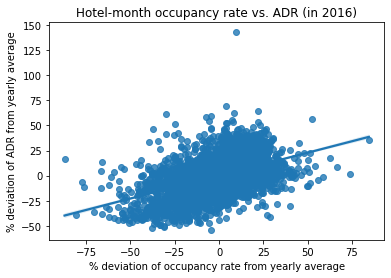

In [557]:

import seaborn as sns
df_16 = df_data[df_data["year"]==2016]

year_avg = df_16.groupby("shareid")["Occ"].mean().reset_index().rename(columns={"Occ":"year_avg_occ"})
adr_avg =  df_16.groupby("shareid")["ADR"].mean().reset_index().rename(columns={"ADR":"year_avg_adr"})

df_16 = df_16.merge(year_avg, on="shareid", how="left").merge(adr_avg, on="shareid", how="left")

df_16["dev_occ"] = (df_16["Occ"]-df_16["year_avg_occ"])*100/df_16["year_avg_occ"]
df_16["dev_adr"] = (df_16["ADR"]-df_16["year_avg_adr"])*100/df_16["year_avg_adr"]

test = df_16

ax = sns.regplot(test['dev_occ'],test['dev_adr'])
ax.set_xlabel("% deviation of occupancy rate from yearly average")
ax.set_ylabel("% deviation of ADR from yearly average")
ax.set_title("Hotel-month occupancy rate vs. ADR (in 2016)")

In [558]:
df_data.shape

(67670, 69)

In [559]:

class_group_dict = {
    1:"luxury_group",
    2:"upscale_group",
    3:"upscale_group",
    4:"economy_group",
    5:"economy_group",
    6:"economy_group"    
}

In [560]:
df_data["Class Group"] = df_data["Class"].map(class_group_dict)

In [561]:
df_data["hotel_age"] = 2016 - df_data["OpenDate"]
df_data["hotel_age"] = df_data["hotel_age"].fillna(df_data["hotel_age"].mean())

In [562]:
#df.to_csv(os.path.join(input_dir,r"chain_crowd_out.csv"), index=False)

In [563]:
# calculate market share

l=[]
for i in (0,1,2):
    
    data = df_data[df_data["Market"]==df_data["Market"].unique()[i]]
    
    test_1 = data.groupby(["month","year"])["Supply"].sum().reset_index().rename(columns={"Supply":"Market Monthly Supply"})
    test_7 = data.groupby(["month","year"])["Demand"].sum().reset_index().rename(columns={"Demand":"Market Monthly Demand"})
    test_2 = data.groupby(["month","year","Class Group"])["Demand"].sum().reset_index().rename(columns={"Demand":"Group Monthly Demand"})
    test_10 = data.groupby(["month","year","Class Group"])["Supply"].sum().reset_index().rename(columns={"Supply":"Group Monthly Supply"})
    test_3 = data.groupby(["month","year"])["shareid"].nunique().reset_index().rename(columns={"shareid":"hotel_count_in_market"})
    #number of chain hotels
    test_4 = data[data["Operation"]==1].groupby(["month","year","Class Group"])["shareid"].nunique().reset_index().rename(columns={"shareid":"hotel_count_in_group_chain"})
    #number of franchised hotels
    test_5 = data[data["Operation"]==2].groupby(["month","year","Class Group"])["shareid"].nunique().reset_index().rename(columns={"shareid":"hotel_count_in_group_franchised"})
    #number of independent hotels
    test_6 = data[data["Operation"]==3].groupby(["month","year","Class Group"])["shareid"].nunique().reset_index().rename(columns={"shareid":"hotel_count_in_group_independent"})
    #number of hotel by size
    test_8_temp = data.groupby(["month","year","Class Group","SizeCode"])["shareid"].nunique()\
             .reset_index().rename(columns={"shareid":"hotel count"})
    test_8 = pd.pivot_table(data = test_8_temp,\
                            columns="SizeCode",\
                            index=["month","year","Class Group"],\
                            values = "hotel count").reset_index().rename_axis(None, axis=1)
    test_8 = test_8.rename(columns={1:"1_size", 2:"2_size",3:"3_size",4:"4_size",5:"5_size"})
    # hotel age
    test_9 = data.groupby(["month","year","Class Group"])["hotel_age"].mean().reset_index().rename(columns={"hotel_age":"Group Avg Age"})
   
    test = test_2.merge(test_4, on=["month","year", "Class Group"], how="left")\
                 .merge(test_5, on=["month","year", "Class Group"], how="left")\
                 .merge(test_6, on=["month","year", "Class Group"], how="left")\
                 .merge(test_8, on=["month","year", "Class Group"], how="left")\
                 .merge(test_9, on=["month","year", "Class Group"], how="left")\
                 .merge(test_10, on=["month","year", "Class Group"], how="left")\
                 .merge(test_1, on=["month","year"], how="left")\
                 .merge(test_7, on=["month","year"], how="left")\
                 .merge(test_3, on=["month","year"], how="left")
    
    temp = data.merge(test, on=["year","month","Class Group"], how="left")
    temp["market_share"] = temp["Demand"]/max(temp["Market Monthly Supply"])
    temp["group_share"] = temp["Demand"]/temp["Group Monthly Demand"]
    temp["s_0"] = 1- temp["Market Monthly Demand"]/max(temp["Market Monthly Supply"])
    

    l.append(temp)

df = pd.concat(l,axis=0).fillna(0).reset_index()    


In [564]:
df

,index,post_month,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,...,4_size,5_size,Group Avg Age,Group Monthly Supply,Market Monthly Supply,Market Monthly Demand,hotel_count_in_market,market_share,group_share,s_0
0,0,2016-08,75909,2016-08-01,2170.0,1464.0,209160.00,67.4654,142.868852,96.387097,...,0.0,0.0,53.666667,22624.0,317948.0,233931.0,62,0.004582,0.083447,0.267783
1,1,2016-09,75909,2016-09-01,2100.0,700.0,75000.00,33.3333,107.142857,35.714286,...,0.0,0.0,53.666667,21562.0,307353.0,198883.0,61,0.002191,0.049787,0.377485
2,2,2016-10,75909,2016-10-01,2170.0,1123.0,123965.00,51.7511,110.387355,57.126728,...,0.0,0.0,53.666667,22129.0,318763.0,202890.0,61,0.003515,0.071812,0.364943
3,3,2016-11,75909,2016-11-01,1956.0,1282.0,201327.00,65.5419,157.041342,102.927914,...,0.0,0.0,53.666667,21266.0,309710.0,219674.0,61,0.004013,0.077523,0.312408
4,4,2016-12,75909,2016-12-01,2003.0,1020.0,199453.00,50.9236,195.542157,99.577134,...,0.0,0.0,53.666667,22110.0,319483.0,224706.0,61,0.003193,0.065679,0.296657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67665,16307,2016-10,9990853,2016-10-01,12865.0,12529.0,3048074.00,97.3882,243.281507,236.927633,...,8.0,3.0,18.866667,179253.0,1210161.0,1027382.0,116,0.010353,0.083271,0.151037
67666,16308,2016-11,9990853,2016-11-01,12450.0,10838.0,2654683.00,87.0522,244.942148,213.227550,...,8.0,3.0,17.687500,178343.0,1185221.0,926959.0,119,0.008956,0.080494,0.234020
67667,16309,2016-12,9990853,2016-12-01,12865.0,9415.0,1328682.00,73.1830,141.123951,103.278818,...,8.0,3.0,16.647059,190297.0,1206439.0,683632.0,118,0.007780,0.091780,0.435090
67668,16310,2016-11,10127842,2016-11-01,648.0,120.0,9363.02,18.5185,78.025167,14.449105,...,0.0,1.0,31.615385,125628.0,1185221.0,926959.0,119,0.000099,0.001339,0.234020


In [565]:

df["Rating"] = df["accum_rating"]*df["is_reviewed"]
df["Rating"] = df["Rating"].fillna(0)

In [566]:
# using competitors capacity as instruments
supply_max = data.groupby(["shareid"])["Supply"].max().reset_index().rename(columns={"Supply":"max_supply"})
df = df.merge(supply_max, on=["shareid"], how="left")
df["capacity"] = df["max_supply"]/30



In [567]:
df["competitor_occ"] = (df["Group Monthly Demand"]-df["Demand"])/(df["Group Monthly Supply"]-df["Supply"])

In [568]:
df

,index,post_month,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,...,Market Monthly Supply,Market Monthly Demand,hotel_count_in_market,market_share,group_share,s_0,Rating,max_supply,capacity,competitor_occ
0,0,2016-08,75909,2016-08-01,2170.0,1464.0,209160.00,67.4654,142.868852,96.387097,...,317948.0,233931.0,62,0.004582,0.083447,0.267783,4.842105,NaN,NaN,0.786154
1,1,2016-09,75909,2016-09-01,2100.0,700.0,75000.00,33.3333,107.142857,35.714286,...,307353.0,198883.0,61,0.002191,0.049787,0.377485,4.842105,NaN,NaN,0.686466
2,2,2016-10,75909,2016-10-01,2170.0,1123.0,123965.00,51.7511,110.387355,57.126728,...,318763.0,202890.0,61,0.003515,0.071812,0.364943,4.850000,NaN,NaN,0.727241
3,3,2016-11,75909,2016-11-01,1956.0,1282.0,201327.00,65.5419,157.041342,102.927914,...,309710.0,219674.0,61,0.004013,0.077523,0.312408,4.843478,NaN,NaN,0.790005
4,4,2016-12,75909,2016-12-01,2003.0,1020.0,199453.00,50.9236,195.542157,99.577134,...,319483.0,224706.0,61,0.003193,0.065679,0.296657,4.822695,NaN,NaN,0.721639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67665,16307,2016-10,9990853,2016-10-01,12865.0,12529.0,3048074.00,97.3882,243.281507,236.927633,...,1210161.0,1027382.0,116,0.010353,0.083271,0.151037,4.598155,12865.0,428.833333,0.828972
67666,16308,2016-11,9990853,2016-11-01,12450.0,10838.0,2654683.00,87.0522,244.942148,213.227550,...,1185221.0,926959.0,119,0.008956,0.080494,0.234020,4.596921,12865.0,428.833333,0.746300
67667,16309,2016-12,9990853,2016-12-01,12865.0,9415.0,1328682.00,73.1830,141.123951,103.278818,...,1206439.0,683632.0,118,0.007780,0.091780,0.435090,4.597366,12865.0,428.833333,0.525086
67668,16310,2016-11,10127842,2016-11-01,648.0,120.0,9363.02,18.5185,78.025167,14.449105,...,1185221.0,926959.0,119,0.000099,0.001339,0.234020,3.000000,744.0,24.800000,0.716115


# Calculate residuals of price on ratings

In [569]:
from statsmodels.api import add_constant
from linearmodels import IV2SLS

OH = OneHotEncoder(handle_unknown='ignore')

fe_var= ["year"]

x_fe = OH.fit_transform(df[fe_var]).toarray()
fe_var_cols = OH.fit(df[fe_var]).get_feature_names_out().tolist()

fe_var_df_4 = pd.DataFrame(x_fe, columns=fe_var_cols)

con_var_list = ["Rating","is_reviewed"]
con_var_df = df[con_var_list]

x_temp = pd.concat([con_var_df,fe_var_df_4], axis=1).astype(float)
x_temp["Y2000_Rating"] = x_temp["year_2000"]*x_temp["Rating"]
x_temp["Y2001_Rating"] = x_temp["year_2001"]*x_temp["Rating"]
x_temp["Y2002_Rating"] = x_temp["year_2002"]*x_temp["Rating"]
x_temp["Y2003_Rating"] = x_temp["year_2003"]*x_temp["Rating"]
x_temp["Y2004_Rating"] = x_temp["year_2004"]*x_temp["Rating"]
x_temp["Y2005_Rating"] = x_temp["year_2005"]*x_temp["Rating"]
x_temp["Y2006_Rating"] = x_temp["year_2006"]*x_temp["Rating"]
x_temp["Y2007_Rating"] = x_temp["year_2007"]*x_temp["Rating"]
x_temp["Y2008_Rating"] = x_temp["year_2008"]*x_temp["Rating"]
x_temp["Y2009_Rating"] = x_temp["year_2009"]*x_temp["Rating"]
x_temp["Y2010_Rating"] = x_temp["year_2010"]*x_temp["Rating"]
x_temp["Y2011_Rating"] = x_temp["year_2011"]*x_temp["Rating"]
x_temp["Y2012_Rating"] = x_temp["year_2012"]*x_temp["Rating"]
x_temp["Y2013_Rating"] = x_temp["year_2013"]*x_temp["Rating"]
x_temp["Y2014_Rating"] = x_temp["year_2014"]*x_temp["Rating"]
x_temp["Y2015_Rating"] = x_temp["year_2015"]*x_temp["Rating"]
x_temp["Y2016_Rating"] = x_temp["year_2016"]*x_temp["Rating"]
#x_temp["Y2017_Rating"] = x_temp["year_2017"]*x_temp["Rating"]

x_temp["Y2000_reviewed"] = x_temp["year_2000"]*x_temp["is_reviewed"]
x_temp["Y2001_reviewed"] = x_temp["year_2001"]*x_temp["is_reviewed"]
x_temp["Y2002_reviewed"] = x_temp["year_2002"]*x_temp["is_reviewed"]
x_temp["Y2003_reviewed"] = x_temp["year_2003"]*x_temp["is_reviewed"]
x_temp["Y2004_reviewed"] = x_temp["year_2004"]*x_temp["is_reviewed"]
x_temp["Y2005_reviewed"] = x_temp["year_2005"]*x_temp["is_reviewed"]
x_temp["Y2006_reviewed"] = x_temp["year_2006"]*x_temp["is_reviewed"]
x_temp["Y2007_reviewed"] = x_temp["year_2007"]*x_temp["is_reviewed"]
x_temp["Y2008_reviewed"] = x_temp["year_2008"]*x_temp["is_reviewed"]
x_temp["Y2009_reviewed"] = x_temp["year_2009"]*x_temp["is_reviewed"]
x_temp["Y2010_reviewed"] = x_temp["year_2010"]*x_temp["is_reviewed"]
x_temp["Y2011_reviewed"] = x_temp["year_2011"]*x_temp["is_reviewed"]
x_temp["Y2012_reviewed"] = x_temp["year_2012"]*x_temp["is_reviewed"]
x_temp["Y2013_reviewed"] = x_temp["year_2013"]*x_temp["is_reviewed"]
x_temp["Y2014_reviewed"] = x_temp["year_2014"]*x_temp["is_reviewed"]
x_temp["Y2015_reviewed"] = x_temp["year_2015"]*x_temp["is_reviewed"]
x_temp["Y2016_reviewed"] = x_temp["year_2016"]*x_temp["is_reviewed"]
#x_temp["Y2017_reviewed"] = x_temp["year_2017"]*x_temp["is_reviewed"]



In [570]:
con_var_df = x_temp[["Y2000_Rating","Y2001_Rating","Y2002_Rating","Y2003_Rating",\
                    "Y2004_Rating","Y2005_Rating","Y2006_Rating","Y2007_Rating",\
                    "Y2008_Rating","Y2009_Rating","Y2010_Rating","Y2011_Rating",\
                    "Y2012_Rating","Y2013_Rating","Y2014_Rating","Y2015_Rating",\
                    "Y2016_Rating",\
                   # "Y2000_reviewed","Y2001_reviewed","Y2002_reviewed","Y2003_reviewed",\
                  #  "Y2004_reviewed","Y2005_reviewed","Y2006_reviewed","Y2007_reviewed",\
                   # "Y2008_reviewed","Y2009_reviewed","Y2010_reviewed","Y2011_reviewed",\
                   # "Y2012_reviewed","Y2013_reviewed","Y2014_reviewed","Y2015_reviewed",\
                  #  "Y2016_reviewed","Y2017_reviewed",\
                   "is_reviewed"]]


fe_var= ["shareid","market_year_month"]

x_fe = OH.fit_transform(df[fe_var]).toarray()
fe_var_cols = OH.fit(df[fe_var]).get_feature_names_out().tolist()

fe_var_df_4 = pd.DataFrame(x_fe, columns=fe_var_cols)


x_4 = pd.concat([con_var_df,fe_var_df_4], axis=1)
x_4 = sm.add_constant(x_4)

In [571]:
model_4 = sm.OLS(df["ADR"], x_4)
results_4 = model_4.fit(cov_type="cluster",cov_kwds={"groups":df["shareid"]})

In [572]:
df["p_star"] = results_4.resid

# Calculate residuals of utility on price and rating

In [573]:
sigma = 0.54
df["delta"]=np.log(df["market_share"])-np.log(df["s_0"])-sigma*np.log(df["group_share"])


In [574]:
con_var_df = x_temp[["Y2000_Rating","Y2001_Rating","Y2002_Rating","Y2003_Rating",\
                    "Y2004_Rating","Y2005_Rating","Y2006_Rating","Y2007_Rating",\
                    "Y2008_Rating","Y2009_Rating","Y2010_Rating","Y2011_Rating",\
                    "Y2012_Rating","Y2013_Rating","Y2014_Rating","Y2015_Rating",\
                    "Y2016_Rating",\
                   # "Y2000_reviewed","Y2001_reviewed","Y2002_reviewed","Y2003_reviewed",\
                  #  "Y2004_reviewed","Y2005_reviewed","Y2006_reviewed","Y2007_reviewed",\
                   # "Y2008_reviewed","Y2009_reviewed","Y2010_reviewed","Y2011_reviewed",\
                   # "Y2012_reviewed","Y2013_reviewed","Y2014_reviewed","Y2015_reviewed",\
                  #  "Y2016_reviewed","Y2017_reviewed",\
                   "is_reviewed"]]


fe_var= ["shareid","market_year_month"]

x_fe = OH.fit_transform(df[fe_var]).toarray()
fe_var_cols = OH.fit(df[fe_var]).get_feature_names_out().tolist()

fe_var_df_4 = pd.DataFrame(x_fe, columns=fe_var_cols)


x_4 = pd.concat([con_var_df,df["ADR"],fe_var_df_4], axis=1)
x_4 = sm.add_constant(x_4)

In [575]:
model_4 = sm.OLS(df["delta"], x_4)
results_4 = model_4.fit(cov_type="cluster",cov_kwds={"groups":df["shareid"]})

In [576]:
df["delta_epsilon_ols"] =  results_4.resid

In [577]:
alpha_ols = results_4.params["ADR"]

In [578]:
df["lambda"] = 1/(1/(1-sigma)-df["market_share"]-sigma*df["group_share"]/(1-sigma))

In [579]:
## cov(p*, lambda)

df[["p_star","lambda"]].cov().iloc[1,0]/np.var(df["p_star"])

-1.4157382045105228e-06

In [580]:
np.var(df["p_star"])

472.35327080054714

In [581]:
df[["delta_epsilon_ols","lambda"]].cov().iloc[1,0]/np.var(df["p_star"])

1.8355625795604308e-07

In [582]:
occ_upper = 88
df["q_upper"] = df["Supply"]*occ_upper/100

df_lower = df[df["Demand"]<=df["q_upper"]]
df_upper = df[df["Demand"]>df["q_upper"]]

df_lower["excess_demand"] =0
df_upper["excess_demand"] = df_upper["Demand"]-df_upper["q_upper"]
df = pd.concat([df_lower,df_upper],axis=0).reset_index()

/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [583]:
df = df.drop(["level_0", "index"],axis=1)

In [584]:
df["excess_demand"]

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
          ...  
67665     640.0
67666     641.8
67667     223.8
67668     327.0
67669    1207.8
Name: excess_demand, Length: 67670, dtype: float64

In [653]:
def demand_est(r,df,alpha_ols):
    alpha = r[0]
    c_1=r[1]
    g =c_1*df["excess_demand"]
    df["g"]=g
    moment_1 = (1-df[["p_star","g"]].cov().iloc[1,0]/np.var(df["p_star"]))*alpha**2+\
          (df[["delta_epsilon_ols","lambda"]].cov().iloc[1,0]/np.var(df["p_star"])-alpha_ols +\
          alpha_ols*df[["p_star","g"]].cov().iloc[1,0]/np.var(df["p_star"])+\
           df[["delta_epsilon_ols","g"]].cov().iloc[1,0]/np.var(df["p_star"]))*alpha+\
                   ((-alpha_ols)*df[["p_star","lambda"]].cov().iloc[1,0]/np.var(df["p_star"])-\
                    df[["delta_epsilon_ols","lambda"]].cov().iloc[1,0]/np.var(df["p_star"]))
    
    moment_2 = (np.log(df["market_share"])-np.log(df["s_0"])-sigma*np.log(df["group_share"])-alpha*df["ADR"]-g)*df["competitor_occ"]
    #moment_2 = (alpha*df["ADR"]+df["lambda"]-g)*df["competitor_occ"]
    
    
    return moment_1**2+np.mean(moment_2**2) 
            

In [654]:

from scipy import optimize
from scipy.optimize import Bounds
bounds = Bounds(np.nan, 0)


res = optimize.minimize(demand_est, x0 =[5,5] , args = (df,alpha_ols), options={'disp': True})

Optimization terminated successfully.
         Current function value: 1.832724
         Iterations: 8
         Function evaluations: 45
         Gradient evaluations: 15


In [655]:
alpha = res.x[0]

In [656]:
c_1 = res.x[1]

In [674]:
from statsmodels.api import add_constant
from linearmodels import IV2SLS
OH = OneHotEncoder(handle_unknown='ignore')

dep=df["ADR"]+1/(-0.2*(1/(1-sigma)-\
                                (sigma*df["group_share"]/(1-sigma))-\
                                df["market_share"]))-0.1*df["excess_demand"]

fe_var= ["shareid","market_year_month"]

x_fe = OH.fit_transform(df[fe_var]).toarray()
fe_var_cols = OH.fit(df[fe_var]).get_feature_names_out().tolist()
fe_var_df_1 = pd.DataFrame(x_fe, columns=fe_var_cols)


x = fe_var_df_1
#x = sm.add_constant(x)

In [675]:
model= sm.OLS(dep, x)
results= model.fit(cov_type="cluster",cov_kwds={"groups":df["shareid"]})

Text(0.5, 1.0, 'Equilibrium vs. Actual Market Shares')

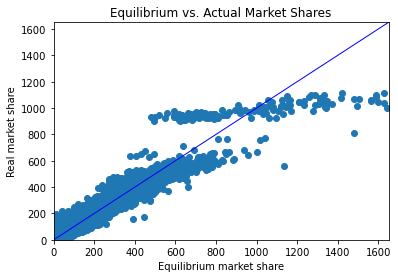

In [676]:
plt.scatter(dep,results.fittedvalues)
plt.plot([0, 1700], [0, 1700], color = 'blue', linewidth = 1)
plt.xlim([0,1650])
plt.ylim([0,1650])
plt.xlabel("Equilibrium market share")
plt.ylabel("Real market share")
plt.title("Equilibrium vs. Actual Market Shares")

In [677]:
alpha

-0.012244694224825678

In [658]:
c_1

0.0003778737072207498

In [695]:
alpha_test = -0.012

In [696]:
df["elasticity"] = alpha_test*df["ADR"]*(1/(1-sigma)-\
                                (sigma*df["group_share"]/(1-sigma))-\
                                df["market_share"])

(array([15913.,  2953.,  3543.,  4177.,  4555.,  4508.,  4842.,  4902.,
         4608., 17669.]),
 array([-4.16516256, -3.91307202, -3.66098147, -3.40889093, -3.15680039,
        -2.90470984, -2.6526193 , -2.40052876, -2.14843821, -1.89634767,
        -1.64425713]),
 <BarContainer object of 10 artists>)

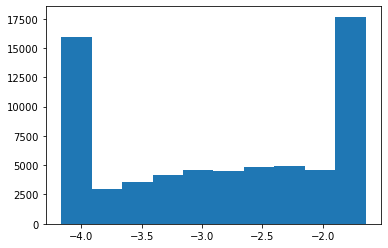

In [704]:
from scipy.stats.mstats import winsorize
df["elasticity"] = winsorize(df["elasticity"], limits=[0.2, 0.2])
plt.hist(df["elasticity"])

In [705]:
df["ADR"].mean()

123.51016376858675